In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pip install pydicom

In [ ]:
#Libraries

import os
import PIL
import cv2
import tarfile
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
import skimage.io
import skimage.color
import skimage.filters
from scipy import signal
import os
import cv2
import numpy as np
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
from PIL import Image
from scipy import ndimage as ndi
from skimage import data
from skimage import data, morphology

In [ ]:
# The Code to extract the files into Drive. It needs to be run only once in the beginning. 

# Create Data Directory
if not os.path.isdir("/content/drive/MyDrive/BRATS/Data"):
    os.makedirs("/content/drive/MyDrive/BRATS/Data", exist_ok=True)
    
# Load Competition Training Dataframe
train_df = pd.read_csv("/content/drive/MyDrive/BRATS/train_labels.csv")

# Extract Update
print("\n... Extracting BraTSID=00495 Task1 Update Files ...")
tar = tarfile.open("/content/drive/MyDrive/BRATS/BraTS2021_00495.tar")
tar.extractall("/content/drive/MyDrive/BRATS/Data")
tar.close()

# Extract Update
print("... Extracting BraTSID=00621 Task1 Update Files ...")
tar = tarfile.open("/content/drive/MyDrive/BRATS/BraTS2021_00621.tar")
tar.extractall("/content/drive/MyDrive/BRATS/Data")
tar.close()

# Extract Main Training Data
print("... Extracting Main Task1 Training Files (3-5 Minutes) ...\n")
tar = tarfile.open("/content/drive/MyDrive/BRATS/BraTS2021_Training_Data.tar")
tar.extractall("/content/drive/MyDrive/BRATS/Data")
tar.close()

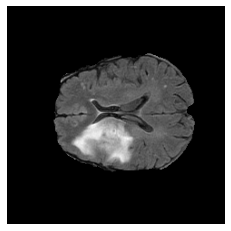

In [ ]:
# Visualization of an image for a given slice and patient.

img_ids = ["00100"]  # Chosing 1 image for the test
Slice = 83  # Chosing 1 slice of the image

for img_id in img_ids:
  for i, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_{s_type}.nii.gz' for s_type in ["flair"]]):
        # Using FLAIR only for now..
        image = nib.load(nii).get_fdata()
        M = ((image[:, :, Slice]).max())
        Im_ = (image[:, :, Slice])*255/M    # Normalize the Image's values
        plt.axis("off")
        plt.imshow(Im_, cmap='gray')
        

for img_id in img_ids:
  for i, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_{s_type}.nii.gz' for s_type in ["seg"]]):
        # Getting the Ground Truth Image..
        GT = nib.load(nii).get_fdata()
        MGT = ((GT[:, :, Slice]).max())
        GT_ = (GT[:, :, Slice])*255/MGT    # Normalize the Image's values

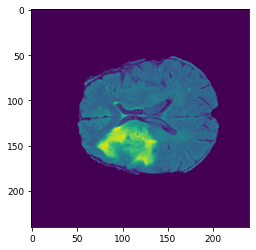

In [ ]:
plt.imshow(Im_)

In [ ]:
# --------   Contrast Enhancement - Histogram Stretching :
# Function to map each intensity level to output intensity level.
def pixelVal(pix, r1, s1, r2, s2):
    if (0 <= pix and pix <= r1):
        return (s1 / r1)*pix
    elif (r1 < pix and pix <= r2):
        return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
    else:
        return ((255 - s2)/(255 - r2)) * (pix - r2) + s2

def contrastEnhance(Im):
  # Define parameters.
  r1 = 70
  s1 = 0
  r2 = 150
  s2 = 255
  # Vectorize the function to apply it to each value in the Numpy array.
  pixelVal_vec = np.vectorize(pixelVal)    
  # Apply contrast stretching.
  contrast_stretched = pixelVal_vec(Im, r1, s1, r2, s2)
  return contrast_stretched

In [ ]:
## Kmeans application + Binarization

# Documentation: https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html

def segment_kmeans(Im_, GT_):

  k=5
  attempts=10

  # Setting the font size for all plots.
  plt.rcParams['font.size'] = 9
  # The input image.
  image = Im_

  #Applying k means for k clusters

  img2=image.reshape((-1,1)) 
  ## Reshape the array into a different size of an array. Because it enables us to apply kmeans algorithm.
  
  img2=np.float32(img2)
  ## Array type is uint8 to run kmeans clustering in opencv, it needs to be float32

  criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ## cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER: stop the iteration when if specified accuracy, epsilon, is reached or specified number of iterations, max_iter achieved.
  # max iteration=10, epsilon=1.0

  ret,label,center=cv2.kmeans(img2,k,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)
  # ret= compactness : It is the sum of squared distance from each point to their corresponding centers.
  # labels : This is the label array (same as 'code' in previous article) where each element marked '0', '1'.....
  # centers : This is array of centers of each clusters.

  center= np.uint8(center) # convert it into unsigned integer so that we can plot it
  res=center[label.flatten()] 

  res2=res.reshape((image.shape)) ## reshape back to the original image

  # Normalization
  image = (image - np.min(image))* (255 / (np.max(image) - np.min(image)))
  res2 = (res2 - np.min(res2))* (255 / (np.max(res2) - np.min(res2))) #sgementation from kmeans

  ret,thresh1 = cv2.threshold(res2,250,255,cv2.THRESH_BINARY)
  #https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
  ## Apply binary threshold to the image

  return thresh1

In [ ]:
## morphological operations opening 

def opening(kmeans_result):

    SE = [[0, 0, 1, 1, 1, 0, 0],
          [0, 1, 1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1],
          [0, 1, 1, 1, 1, 1, 0],
          [0, 0, 1, 1, 1, 0, 0]]
          
    Op = morphology.binary_opening(kmeans_result, SE) 
    return Op

In [ ]:
# Calculate Dice coefficient

def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

In [ ]:
## Comparison and Dice Index

def comparison(Im_, kmeans_result, GT_):
  # Comparison with the Mask (manually segmented image) and the result from K-Means
  ground_t=GT_
  ground_t = ground_t>0
  ground_t = ground_t.astype(int) #it is between 0-1

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

  # Plotting the original image.
  ax[0].imshow(Im_, cmap='gray') #Im_ between 0-255
  ax[0].set_title('Original')
  ax[0].axis('off')

  # Plotting GT

  ax[1].imshow(ground_t, cmap='gray')
  ax[1].set_title('Ground Truth')
  ax[1].axis('off')

  ax[2].imshow(kmeans_result, cmap='gray')
  ax[2].set_title('Kmeans+Opening')
  ax[2].axis('off')

  dice=dice_coef2(ground_t, kmeans_result)
  print("The Dice Coefficient is: ", dice)

  plt.subplots_adjust()

  plt.show()

  return dice

The Dice Coefficient is:  0.9511241446725318


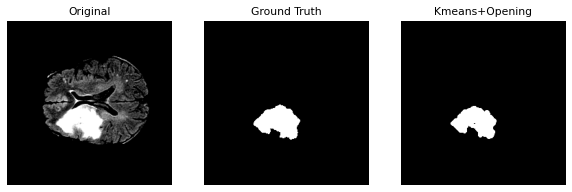

The Dice Coefficient is:  0.9224762967094255


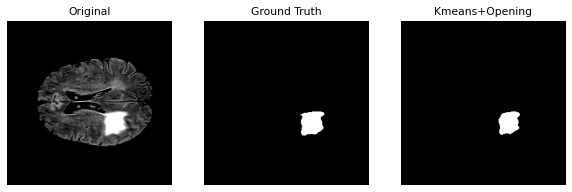

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


The Dice Coefficient is:  0.0


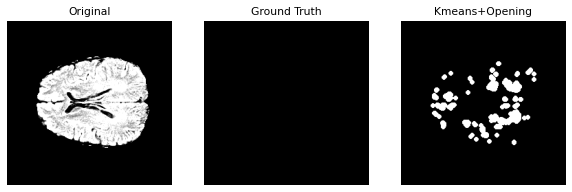

The Dice Coefficient is:  0.8701280427747291


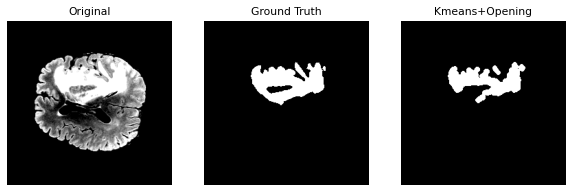

The Dice Coefficient is:  0.16683283482884678


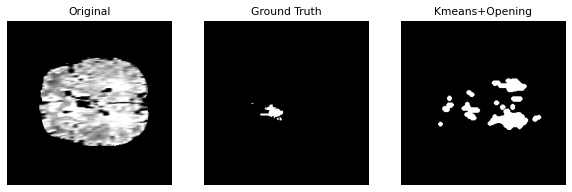

The Dice Coefficient is:  0.5598621877691645


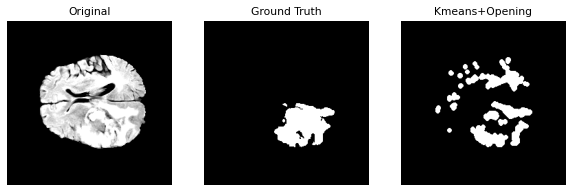

The Dice Coefficient is:  0.9254032258064516


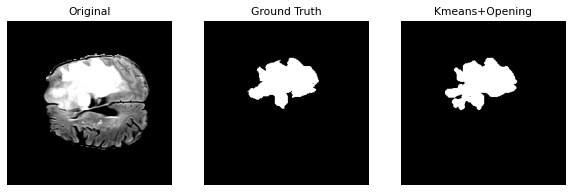

The average dice is: 0.6279752475087356


In [ ]:
j = 83
count=0
dicesum=0
for i in range(100,107):
  img_id = "00" + str(i)
  for n, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_flair.nii.gz']):
      try:
        image = nib.load(nii).get_fdata()
      except FileNotFoundError:
        print(f'Image {img_id} does not exist')
        continue

      M= ((image[:, :, j]).max())
      Im_ = (image[:, :, j])*255/M   
      Im_=contrastEnhance(Im_)

  for n, nii in enumerate([f'/content/drive/MyDrive/BRATS/Data/BraTS2021_{img_id}/BraTS2021_{img_id}_seg.nii.gz']):
      try:
        gt = nib.load(nii).get_fdata()
      except FileNotFoundError:
        print(f'Image {img_id} does not exist')
        continue

      GT = nib.load(nii).get_fdata()
      MGT = ((GT[:, :, Slice]).max())
      GT_ = (GT[:, :, Slice])*255/MGT
            
            
  kmeans_result=segment_kmeans(Im_, GT_)
  kmeans_result= opening(kmeans_result)
  dice= comparison(Im_, kmeans_result, GT_)

  dicesum+=dice
  count+=1

print("The average dice is:", dicesum/count)

In [ ]:
image1=Im_
gt1=GT_

In [ ]:
# All in one 
def k_means_application(Im_, GT_):
  # Contrast stretching
  Im_=contrastEnhance(Im_)
  # K-Means Application
  k=5
  image = Im_
  img2=image.reshape((-1,1)) 
  img2=np.float32(img2)
  criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret,label,center=cv2.kmeans(img2,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  center= np.uint8(center)
  res=center[label.flatten()] 
  res2=res.reshape((image.shape))
  res2 = (res2 - np.min(res2))* (255 / (np.max(res2) - np.min(res2)))
  # Binarization for segmented image
  ret,thresh1 = cv2.threshold(res2,250,255,cv2.THRESH_BINARY)
  # Opening
  SE = [[0, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 0, 0]]
  Op = morphology.binary_opening(thresh1, SE)
  # Comparison
  ground_t=GT_
  ground_t = ground_t>0
  ground_t = ground_t.astype(int) #it is between 0-1
  dice=dice_coef2(ground_t, Op)
  return dice

In [ ]:
k_means_application(image1, gt1)

0.9653679653679653